# Sale Prediction

Some code cited from https://www.kaggle.com/nicapotato/multivar-lstm-ts-regression-keras

In [112]:
import pandas as pd
import numpy as np
from datetime import datetime, date

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
import random

In [115]:
random.seed(1)

In [116]:
# load data
categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("sales_train.csv")

In [117]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [118]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [119]:
train.shape

(2935849, 6)

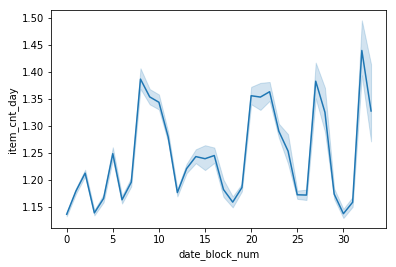

In [120]:
g1 = sns.lineplot(x="date_block_num", y="item_cnt_day", data = train)

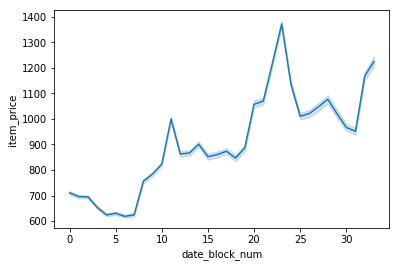

In [121]:
g2 = sns.lineplot(x="date_block_num", y="item_price", data = train)

In [122]:
train_df = train.groupby([train.date_block_num, train.item_id, train.shop_id]).sum().reset_index()

In [123]:
train_df.head()

,date_block_num,item_id,shop_id,item_price,item_cnt_day
0,0,19,25,28.0,1.0
1,0,27,1,1890.0,1.0
2,0,27,2,2499.0,1.0
3,0,27,10,1890.0,1.0
4,0,27,19,2499.0,1.0


In [124]:
train_df.describe()

,date_block_num,item_id,shop_id,item_price,item_cnt_day
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,1.466479e+01,1.068099e+04,3.280585e+01,1.625363e+03,2.267200e+00
std,9.542322e+00,6.238883e+03,1.653701e+01,5.701611e+03,8.649882e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01
25%,6.000000e+00,5.045000e+03,2.100000e+01,2.490000e+02,1.000000e+00
50%,1.400000e+01,1.049700e+04,3.100000e+01,4.990000e+02,1.000000e+00
75%,2.300000e+01,1.606000e+04,4.700000e+01,1.398000e+03,2.000000e+00
max,3.300000e+01,2.216900e+04,5.900000e+01,6.719300e+05,2.253000e+03


In [125]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [126]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


## We are going to use LSTM for data prediction

## factors: item_cnt_day, item_price

In [127]:
count_df = train_df.drop(columns=['item_price'])

In [128]:
count_df.head()

,date_block_num,item_id,shop_id,item_cnt_day
0,0,19,25,1.0
1,0,27,1,1.0
2,0,27,2,1.0
3,0,27,10,1.0
4,0,27,19,1.0


In [129]:
count_df = count_df.pivot_table(index=['item_id','shop_id'], columns='date_block_num',values='item_cnt_day',fill_value=0)
count_df = count_df.reset_index()


In [130]:
count_df.head()

date_block_num,item_id,shop_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
count_df = pd.merge(test,count_df, on=['item_id','shop_id'], how='left').fillna(0)

In [132]:
count_df.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
count_df = count_df.drop(labels=['ID','item_id','shop_id'],axis=1)

In [134]:
count_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
count_df.shape

(214200, 34)

In [136]:
#from sklearn.preprocessing import MinMaxScaler

In [137]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#train["item_price"] = scaler.fit_transform(train["item_price"].values.reshape(-1,1))
train_df2 = train.groupby([train.date_block_num, train.item_id, train.shop_id]).mean().reset_index()
train_df2 = train_df2[['date_block_num','item_id','shop_id','item_price']]
train_df2 = train_df2.pivot_table(index=['item_id','shop_id'], columns='date_block_num',values='item_price',fill_value=0).reset_index()


In [138]:
price_df = pd.merge(test,train_df2,on=['item_id','shop_id'], how='left').fillna(0)
price_df = price_df.drop(labels=['ID','item_id','shop_id'],axis=1)

In [139]:
price_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1999.0,0.0,0.0,0.0,1299.0,1499.0,1499.0,999.166667,749.5,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,899.0,599.0,0.0,599.000000,999.0,1199.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,599.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [140]:
price_df.shape

(214200, 34)

## Create train set

In [62]:
y_train = count_df[33]

In [63]:
y_train.shape

(214200,)

In [64]:
x_count = count_df.drop(labels=[33],axis=1)

In [65]:
x_count.shape

(214200, 33)

In [66]:
x_count = x_count.values.reshape((x_count.shape[0], x_count.shape[1], 1))

In [67]:
x_count.shape

(214200, 33, 1)

In [68]:
x_price = price_df.drop(labels=[33],axis=1)

In [69]:
x_price= x_price.values.reshape((x_price.shape[0], x_price.shape[1], 1))

In [70]:
x_price.shape

(214200, 33, 1)

In [71]:
X = np.append(x_count,x_price,axis=2)

In [72]:
# three dimensional with count and price
X.shape

(214200, 33, 2)

In [73]:
y = y_train.values.reshape((y_train.shape[0], 1))

In [74]:
y.shape

(214200, 1)

## Create test set

In [75]:
test_count_df = count_df.drop(labels=[0],axis=1)
x_count_test = test_count_df.values.reshape((test_count_df.shape[0], test_count_df.shape[1], 1))
test_price_df = price_df.drop(labels=[0],axis=1)
x_price_test = test_price_df.values.reshape((test_price_df.shape[0], test_price_df.shape[1], 1))

In [76]:
print(x_count_test.shape)
print(x_price_test.shape)

(214200, 33, 1)
(214200, 33, 1)


In [77]:
T = np.append(x_count_test, x_price_test, axis=2)

In [78]:
T.shape

(214200, 33, 2)

## Create model

In [89]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [90]:
m_lstm = Sequential()
m_lstm.add(LSTM(16, input_shape=(33, 2), return_sequences=True))
m_lstm.add(LSTM(32))
m_lstm.add(Dense(1))
m_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [91]:
m_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 33, 16)            1216      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________


In [92]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=1, shuffle=False)

In [93]:
X_train.shape

(192780, 33, 2)

In [94]:
X_val.shape

(21420, 33, 2)

In [95]:
y_train.shape

(192780, 1)

In [96]:
y_val.shape

(21420, 1)

In [97]:
callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]

In [99]:
hist = m_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=callbacks_list, batch_size=128, verbose=2, epochs = 2)

Train on 192780 samples, validate on 21420 samples
Epoch 1/2
 - 76s - loss: 32.6029 - mean_squared_error: 32.6029 - val_loss: 0.9679 - val_mean_squared_error: 0.9679
Epoch 2/2
 - 74s - loss: 32.4395 - mean_squared_error: 32.4395 - val_loss: 0.9465 - val_mean_squared_error: 0.9465


In [100]:
y_preict = m_lstm.predict(T)

In [104]:
y_preict

array([[0.63652074],
       [0.16340208],
       [0.9728364 ],
       ...,
       [0.13618213],
       [0.16340208],
       [0.10284904]], dtype=float32)

In [105]:
from numpy import sqrt
from sklearn.metrics import mean_squared_error

In [106]:
rmse = sqrt(mean_squared_error(y,y_preict))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 5.340


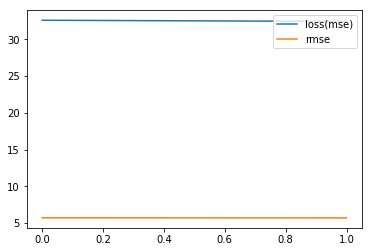

In [107]:
plt.plot(hist.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(hist.history['mean_squared_error']), label= 'rmse')
plt.legend(loc=1)

In [108]:
sub = pd.DataFrame(y_preict,columns=['item_cnt_month'])
sub.to_csv('submission.csv',index_label='ID')

Reference: https://www.kaggle.com/nicapotato/multivar-lstm-ts-regression-keras